In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_path = '../../data/processed/feature_selected_data.parquet'
df = pd.read_parquet(file_path, engine= 'pyarrow')

In [3]:
corr_cols = ['sesso', 
        'regione_residenza', 
        'asl_residenza', 
        'provincia_residenza',
        'comune_residenza',
        'descrizione_attivita',
        'regione_erogazione',
        'asl_erogazione',
        'provincia_erogazione',
        'struttura_erogazione',
        'tipologia_struttura_erogazione',
        'tipologia_professionista_sanitario',
        'eta']

- 'id_paziente' - NO
- 'data_nascita' -  NO
- 'sesso' - SI, con altre
- 'regione_residenza' - SI
- 'asl_residenza' - SI 
- 'provincia_residenza' - SI 
- 'comune_residenza' - SI
- 'tipologia_servizio' - NO
- 'descrizione_attivita' - SI 
- 'data_contatto' - NO
- 'regione_erogazione' -  SI 
- 'asl_erogazione' - SI 
- 'provincia_erogazione' - SI
- 'struttura_erogazione' - SI 
- 'codice_struttura_erogazione' - NO
- 'tipologia_struttura_erogazione' - SI
- 'id_professionista_sanitario' -  NO
- 'tipologia_professionista_sanitario' - SI
- 'data_erogazione' - NO
- 'durata_erogazione_min' - NO
- 'eta' - SI

In [4]:
df['data_erogazione'] = pd.to_datetime(df['data_erogazione'], utc=True)

df['anno'] = df['data_erogazione'].dt.year
df['quadrimestre'] = df['data_erogazione'].dt.quarter

Il codice è una funzione Python che calcola Cramér's V, una misura di correlazione tra due variabili categoriche. Cramér's V è una misura di forza dell'associazione tra due variabili, che varia tra 0 (nessuna associazione) e 1 (associazione perfetta).

1. pd.crosstab(x, y) è una funzione di Pandas che crea una tabella di contingenza. Una tabella di contingenza è una tabella che mostra la frequenza con cui si verificano combinazioni di valori tra le due variabili categoriche x e y.

    - es.  Ad esempio, se x rappresenta il genere (M/F) e y rappresenta il tipo di servizio (A/B), la tabella di contingenza mostrerà quante volte i maschi hanno scelto il servizio A, quante volte hanno scelto il servizio B, e così via per le femmine.

2. chi2_contingency(contingenza) è una funzione di scipy.stats che calcola la statistica del test chi-quadrato per la tabella di contingenza.
    - Il test chi-quadrato verifica l'ipotesi nulla che non ci sia associazione tra le due variabili categoriche.
    - La funzione restituisce diversi valori, tra cui:
        - chi2: il valore della statistica chi-quadrato.
        - _: altri valori che non sono necessari per il calcolo di Cramér's V (p-value, gradi di libertà, frequenze attese), quindi vengono ignorati usando _.

3. contingenza.sum().sum() calcola la somma di tutte le frequenze nella tabella di contingenza, ovvero il numero totale di osservazioni (n). Questo è semplicemente il numero totale di casi nei dati considerati.

4. contingenza.shape restituisce le dimensioni della tabella di contingenza (numero di righe e colonne).
    - min(contingenza.shape) - 1 calcola la dimensione minima meno 1, che serve a normalizzare il valore di chi-quadrato per evitare che sia influenzato dalle dimensioni della tabella.
    - Questo passaggio è necessario per garantire che Cramér's V sia compreso tra 0 e 1, indipendentemente dalle dimensioni delle variabili.

5. Infine, si calcola Cramér's V prendendo la radice quadrata del valore di chi-quadrato diviso per il prodotto del numero totale di osservazioni n e della dimensione minima meno 1 (min_dim).
    - Il risultato è un numero compreso tra 0 e 1:
        - 0 indica nessuna associazione tra le variabili.
        - 1 indica un'associazione perfetta.


In [5]:
# CORRELATION

# Function to calculate Cramer's V
# x and y are the two variables for which we want to calculate the correlation
def cramer_v(x, y):
    # Create a contingency table
    contingenza = pd.crosstab(x, y)
    
    # Calculate the chi-square test statistic and other values
    chi2, _, _, _ = chi2_contingency(contingenza)
    n = contingenza.sum().sum()
    min_dim = min(contingenza.shape) - 1
    
    # Calculate Cramer's V
    return np.sqrt(chi2 / (n * min_dim))

In [6]:
correlations = pd.DataFrame(index=corr_cols, columns=corr_cols)

In [7]:
def calculate_correlation_matrix(df, corr_cols):
    '''
    This function calculates the correlation matrix using Cramér's V.

    Args:
        df: DataFrame containing the data.
        corr_cols: List of columns to calculate the correlation matrix for.

    Returns:
        DataFrame containing the correlation matrix.
    '''
    correlations = pd.DataFrame(index=corr_cols, columns=corr_cols)
    for col1 in corr_cols:
        for col2 in corr_cols:
            if col1 != col2:
                correlations.loc[col1, col2] = cramer_v(df[col1], df[col2])
            else:
                correlations.loc[col1, col2] = 1.0  # Perfect correlation with itself
    return correlations

In [8]:
correlations = calculate_correlation_matrix(df, corr_cols)

In [9]:
def visualize_correlation_matrix(correlations):
    '''
    This function visualizes the correlation matrix using a heatmap.

    Args:
        correlations: DataFrame containing the correlation matrix.

    Returns:
        None
    '''
    plt.figure(figsize=(16, 12))
    sns.heatmap(correlations.astype(float), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)

    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    plt.show()

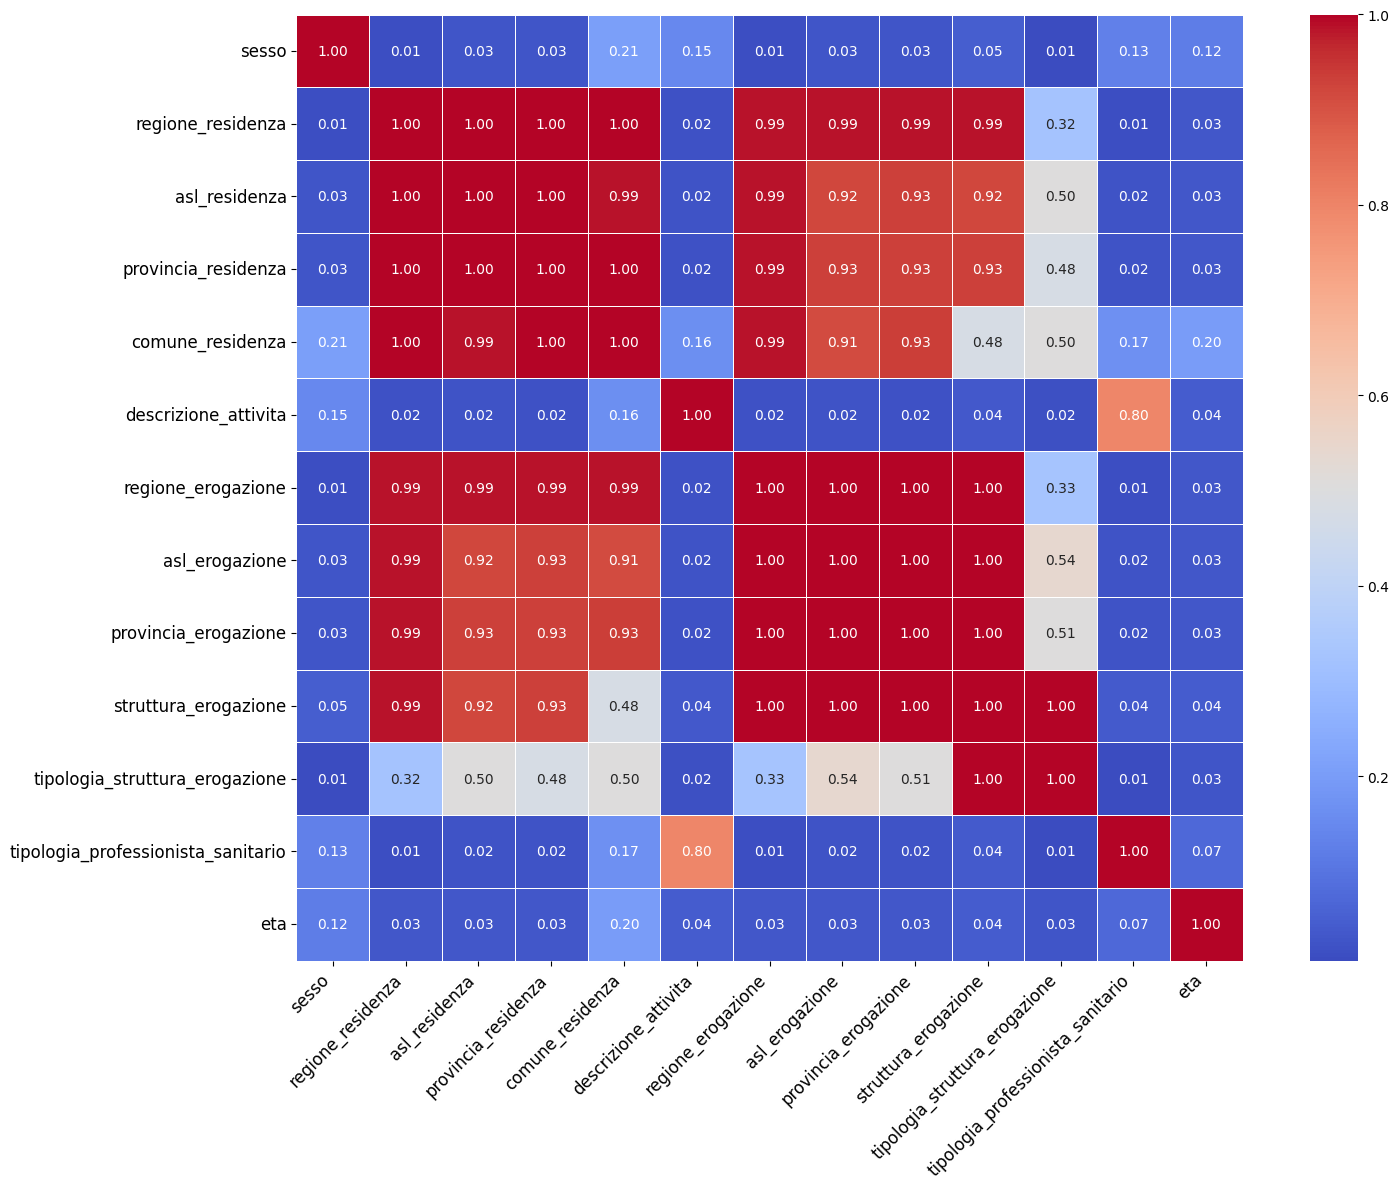

In [10]:
visualize_correlation_matrix(correlations)

## Rimozione delle colonne altamente correlate
Il grafico di correlazione rivela le relazioni tra le varie colonne nel tuo dataset. 
La rimozione delle funzionalità si basa sull'idea di conservare quelle che forniscono la massima granularità e pertinenza per analizzare i modelli che portano all'aumento della teleassistenza. Funzionalità più dettagliate come `comune_residenza`, `struttura_erogazione` e `asl_erogazione` sono più utili per identificare sottili differenze tra gruppi di pazienti, che potrebbero essere cruciali per il clustering supervisionato e comprendere meglio i fattori che contribuiscono all'aumento della teleassistenza.

In [11]:
def remove_highly_correlated_columns(df, columns_to_remove):
    '''
    This function removes columns based on the correlation analysis.

    Args:
        df: DataFrame containing the data.
        columns_to_remove: List of columns to be removed.

    Returns:
        DataFrame with the specified columns removed.
    '''

    df.drop(columns=columns_to_remove, inplace=True)
    return df

In [12]:
columns_to_remove = [
             'comune_residenza', 'asl_residenza', 'provincia_residenza', 'regione_erogazione', 'asl_erogazione', 'provincia_erogazione', 'struttura_erogazione'
     ]


df = remove_highly_correlated_columns(df, columns_to_remove)

# visualizza il df con le colonne rimosse
df.head()

,id_prenotazione,id_paziente,data_nascita,sesso,regione_residenza,tipologia_servizio,descrizione_attivita,data_contatto,codice_struttura_erogazione,tipologia_struttura_erogazione,id_professionista_sanitario,tipologia_professionista_sanitario,data_erogazione,durata_erogazione_sec,eta,anno,quadrimestre
0,JUOCPQCUG1H96QO,LCWFXF28X79P382V,1980-04-24 00:00:00+00:00,male,Piemonte,Teleassistenza,Insegnamento al paziente e/o alla sua famiglia...,2019-01-09T11:21:54+01:00,10906,Azienda Ospedaliera,MZRAER00D13A287J,Infermiere,2019-02-04 10:00:00+00:00,2925.0,44,2019,1
1,XDP99NXRHPOYFYU,LRFZOI94E58U012I,1972-01-30 00:00:00+00:00,female,Toscana,Teleassistenza,Prestazione infermieristica connessa alla nece...,2019-01-10T11:57:43+01:00,90904,Azienda Ospedaliera Universitaria,EBCRPU12T24U316I,Infermiere,2019-02-01 10:00:00+00:00,1895.0,52,2019,1
2,6VYI0AK57ECO5WU,JOBCGJ98A04B765H,1986-06-27 00:00:00+00:00,male,Emilia romagna,Teleassistenza,Prestazione dietistica,2019-01-11T07:04:17+01:00,80053,Ospedale a gestione diretta,PMEJNL62M27F357I,Dietista,2019-02-03 06:00:00+00:00,1165.0,38,2019,1
3,VLFS5J9E3Q74Q2W,TKROSE51Z77Q065E,1967-10-21 00:00:00+00:00,female,Campania,Teleassistenza,Psicoterapia individuale,2019-01-11T07:41:52+01:00,150902,Azienda Ospedaliera,VNNRMQ15C69W200K,Psicologo,2019-02-01 06:00:00+00:00,1969.0,56,2019,1
4,XD8SZX9JOVCMEXW,WRRVSK73Z45L640S,1963-08-24 00:00:00+00:00,male,Abruzzo,Teleassistenza,Prestazione dietistica,2019-01-11T15:33:29+01:00,130018,Ospedale a gestione diretta,GIQCNR34T04P154U,Dietista,2019-02-05 14:00:00+00:00,3099.0,61,2019,1


In [13]:
def recalculate_correlation_matrix(df, corr_cols):
    '''
    This function recalculates the correlation matrix using Cramér's V after removing columns.

    Args:
        df: DataFrame containing the data.
        corr_cols: List of columns to calculate the correlation matrix for.

    Returns:
        DataFrame containing the correlation matrix.
    '''
    return calculate_correlation_matrix(df, corr_cols)


In [14]:
def analyze_feature_correlations(correlations):
    '''
    This function analyzes and prints the correlation between features.

    Args:
        correlations: DataFrame containing the correlation matrix.

    Returns:
        None
    '''
    print("Correlation analysis between features:")
    print(correlations)

In [15]:
def feature_selection_execution(df: pd.DataFrame) -> pd.DataFrame:
    '''
    This function executes the feature selection process.

    Args:
        df: The DataFrame containing the data.

    Returns:
        The DataFrame with removed columns.
    '''
    global columns_pairs

Correlation analysis between features:
                                       sesso regione_residenza  \
sesso                                    1.0          0.013755   
regione_residenza                   0.013755               1.0   
descrizione_attivita                0.148077          0.019799   
tipologia_struttura_erogazione       0.00646          0.324645   
tipologia_professionista_sanitario  0.127727           0.01062   
eta                                 0.119017          0.032041   

                                   descrizione_attivita  \
sesso                                          0.148077   
regione_residenza                              0.019799   
descrizione_attivita                                1.0   
tipologia_struttura_erogazione                 0.016155   
tipologia_professionista_sanitario             0.797724   
eta                                            0.042019   

                                   tipologia_struttura_erogazione  \
sesso          

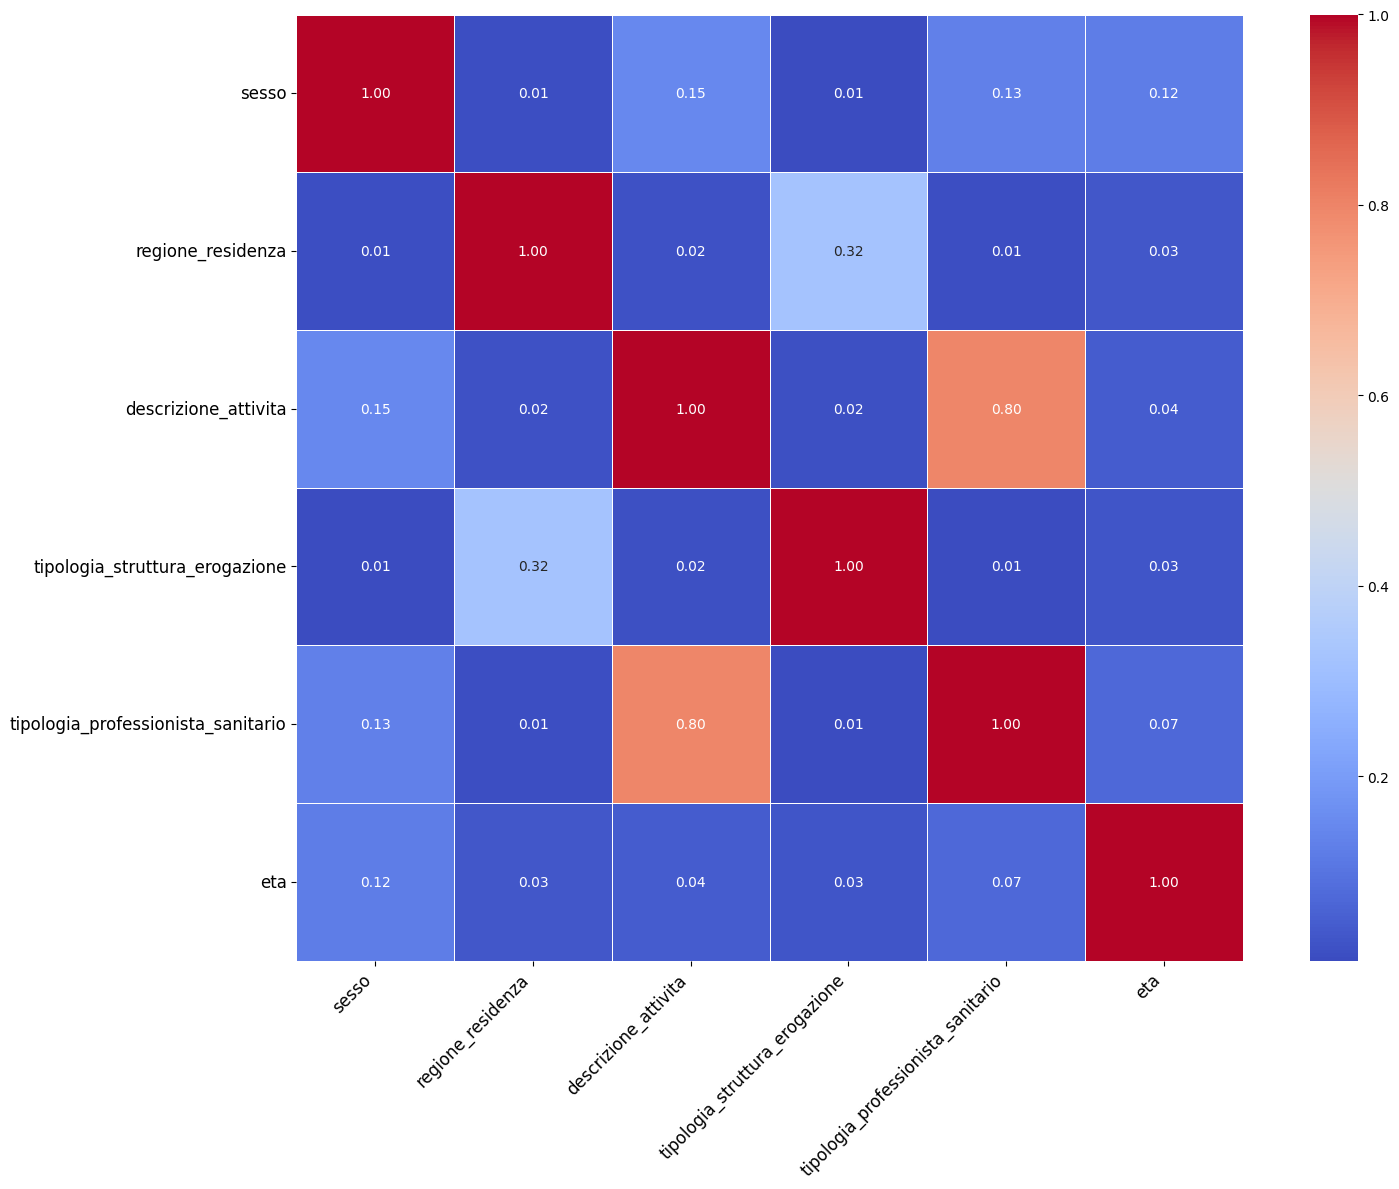

In [16]:
# columns_to_remove = [
#         'regione_residenza', 'asl_residenza', 'provincia_residenza', 'regione_erogazione', 'asl_erogazione', 'provincia_erogazione', 'struttura_erogazione'
#     ]


# Recalculate and analyze correlations after removing columns
corr_cols = ['sesso', 
        'regione_residenza', 
        # 'asl_residenza', 
        # 'provincia_residenza',
        # 'comune_residenza',
        'descrizione_attivita',
        # 'regione_erogazione',
        # 'asl_erogazione',
        # 'provincia_erogazione',
        # 'struttura_erogazione',
        'tipologia_struttura_erogazione',
        'tipologia_professionista_sanitario',
        'eta']

correlations = recalculate_correlation_matrix(df, corr_cols)
analyze_feature_correlations(correlations)
visualize_correlation_matrix(correlations)

# TODO: eliminare le colonne con stessa correlazione
The correlation heatmap you provided reveals the relationships between the various columns in your dataset. Now that you have this information, here's how you can proceed:

1. Identify Highly Correlated Features
Purpose: Features that are highly correlated (close to 1 or -1) with each other might be redundant. You can consider dropping one of the correlated pairs to reduce multicollinearity, which can help in making your model more interpretable and less prone to overfitting.

Example: In your heatmap, the following pairs seem highly correlated:

regione_residenza, asl_residenza, provincia_residenza, comune_residenza <br>
regione_erogazione, asl_erogazione, provincia_erogazione, struttura_erogazione

Action: You can choose to keep only one feature from each highly correlated group. For example:

Keep regione_residenza and drop asl_residenza, provincia_residenza, comune_residenza. <br>
Keep regione_erogazione and drop asl_erogazione, provincia_erogazione, struttura_erogazione.

2. Focus on Less Correlated Features with Target
Purpose: Identify features that have low correlation with each other but might still be valuable for predicting your target variable (e.g., incremento).

Example: The column tipologia_professionista_sanitario shows moderate correlation with descrizione_attivita. This might indicate these two features together could provide valuable information.

3. Select Features for Increment Calculation
Based on your analysis:
Candidate Columns: tipologia_professionista_sanitario, tipologia_struttura_erogazione, and potentially descrizione_attivita if not highly correlated with others.
These columns could be combined to calculate or predict the increment, as they likely offer unique contributions to the variability in your dataset.

4. Evaluate Feature Importance
Purpose: Use feature selection techniques or machine learning models to identify the most important features that contribute to the increment.

In [17]:
df.columns

Index(['id_prenotazione', 'id_paziente', 'data_nascita', 'sesso',
       'regione_residenza', 'tipologia_servizio', 'descrizione_attivita',
       'data_contatto', 'codice_struttura_erogazione',
       'tipologia_struttura_erogazione', 'id_professionista_sanitario',
       'tipologia_professionista_sanitario', 'data_erogazione',
       'durata_erogazione_sec', 'eta', 'anno', 'quadrimestre'],
      dtype='object')